In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


In [21]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report, confusion_matrix

# # Gradient Boosting Models
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier

# Explainability
import shap

# Color Palette
palette = ['#edafb8', '#dedbd2', '#b0c4b1', '#4a5759']
sns.set_palette(palette)
sns.set(rc={"axes.facecolor":"#f7e1d7","figure.facecolor":"#f5f5f5"})
cmap = colors.ListedColormap(palette)
%matplotlib inline

<a id="1"></a>

# <div style="font-family: 'Playfair Display', serif; font-weight:bold; letter-spacing: 1px; color:#edafb8; font-size:150%; text-align:center; padding:10px; background:#4a5759; border-radius: 10px;">📥 1. Data Loading</div>

Let's start by loading the LendingClub dataset. We'll use stratified sampling to ensure balanced class representation.


In [22]:
# Load data
df = pd.read_csv('/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz', low_memory=False)
print(f"Loaded dataset with shape: {df.shape}")

# Filter to completed loans only
completed_statuses = [
    'Fully Paid', 'Charged Off', 'Default', 
    'Late (31-120 days)', 'Late (16-30 days)',
    'Does not meet the credit policy. Status:Fully Paid',
    'Does not meet the credit policy. Status: Charged Off'
]

df = df[df['loan_status'].isin(completed_statuses)].copy()
print(f"Filtered to completed loans: {df.shape[0]:,} rows")

# Show distribution
print("\nLoan status distribution:")
print(df['loan_status'].value_counts())

# Binary target for stratified sampling
target_map = {
    'Fully Paid': 0, 'Charged Off': 1, 'Default': 1, 
    'Late (31-120 days)': 1, 'Late (16-30 days)': 1, 
    'Does not meet the credit policy. Status:Fully Paid': 0,  
    'Does not meet the credit policy. Status: Charged Off': 1
}
temp_target = df['loan_status'].map(target_map)

# Stratified sampling (up to 100k)
# sample_size = min(100000, len(df))
# df, _ = train_test_split(df, train_size=sample_size, stratify=temp_target, random_state=42)

print(f"\nFinal sampled dataset: {df.shape}")

Loaded dataset with shape: (2260701, 151)
Filtered to completed loans: 1,373,154 rows

Loan status distribution:
loan_status
Fully Paid                                            1076751
Charged Off                                            268559
Late (31-120 days)                                      21467
Late (16-30 days)                                        4349
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                    40
Name: count, dtype: int64

Final sampled dataset: (1373154, 151)


In [23]:
# Convert loan_status to binary (0=paid, 1=default)
status_map = {
    'Fully Paid': 0, 'Charged Off': 1, 'Default': 1, 
    'Late (31-120 days)': 1, 'Late (16-30 days)': 1,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    'Does not meet the credit policy. Status:Charged Off': 1
}

print("\nBinary mapping:")
print("  0: Paid (Fully Paid, Policy-Fully Paid)")
print("  1: Default (Charged Off, Default, Late, Policy-Charged Off)")

df['loan_status_binary'] = df['loan_status'].map(status_map).astype(int)

# Class distribution
class_dist = df['loan_status_binary'].value_counts().sort_index()

print(f"\nClass distribution:")
for cls, count in class_dist.items():
    label = "Paid" if cls == 0 else "Default"
    print(f"  {cls} ({label}): {count:,} ({count/len(df)*100:.1f}%)")


Binary mapping:
  0: Paid (Fully Paid, Policy-Fully Paid)
  1: Default (Charged Off, Default, Late, Policy-Charged Off)

Class distribution:
  0 (Paid): 1,078,739 (78.6%)
  1 (Default): 294,415 (21.4%)


In [24]:
print("Dataset Information:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nStatistics:")
df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 1373154 entries, 0 to 2260697
Columns: 152 entries, id to loan_status_binary
dtypes: float64(113), int64(1), object(38)
memory usage: 1.6+ GB
None

Missing Values:
id                             0
member_id                1373154
loan_amnt                      0
funded_amnt                    0
funded_amnt_inv                0
                          ...   
settlement_date          1338956
settlement_amount        1338956
settlement_percentage    1338956
settlement_term          1338956
loan_status_binary             0
Length: 152, dtype: int64

Statistics:


,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,...,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term,loan_status_binary
count,0.0,1.373154e+06,1.373154e+06,1.373154e+06,1.373154e+06,1.373154e+06,1.373150e+06,1.372751e+06,1.373128e+06,1.373154e+06,...,7631.00000,7631.0,7631.000000,5451.000000,7631.000000,7631.000000,34198.000000,34198.000000,34198.000000,1.373154e+06
mean,NaN,1.446082e+04,1.445232e+04,1.442699e+04,1.328514e+01,4.390681e+02,7.626337e+04,1.830978e+01,3.186076e-01,6.961016e+02,...,153.45325,3.0,14.515005,441.783528,11373.131381,192.631862,5009.942763,47.766837,13.194924,2.144079e-01
std,NaN,8.743655e+03,8.739889e+03,8.744737e+03,4.788256e+00,2.621674e+02,7.026864e+04,1.132362e+01,8.800274e-01,3.180987e+01,...,131.54247,0.0,9.451345,378.787841,7629.284695,198.198606,3689.934458,7.299424,8.161496,4.104111e-01
min,NaN,5.000000e+02,5.000000e+02,0.000000e+00,5.310000e+00,4.930000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,6.100000e+02,...,0.64000,3.0,0.000000,1.920000,55.730000,0.010000,44.210000,0.200000,0.000000,0.000000e+00
25%,NaN,8.000000e+03,8.000000e+03,7.925000e+03,9.750000e+00,2.490100e+02,4.575000e+04,1.180000e+01,0.000000e+00,6.700000e+02,...,55.83000,3.0,7.000000,161.460000,5277.805000,45.255000,2208.370000,45.000000,6.000000,0.000000e+00
50%,NaN,1.200000e+04,1.200000e+04,1.200000e+04,1.279000e+01,3.754300e+02,6.500000e+04,1.763000e+01,0.000000e+00,6.900000e+02,...,114.74000,3.0,16.000000,330.990000,9659.450000,130.660000,4147.000000,45.000000,14.000000,0.000000e+00
75%,NaN,2.000000e+04,2.000000e+04,2.000000e+04,1.602000e+01,5.820375e+02,9.000000e+04,2.408000e+01,0.000000e+00,7.100000e+02,...,213.62000,3.0,23.000000,603.975000,15965.080000,280.230000,6850.320000,50.000000,18.000000,0.000000e+00
max,NaN,4.000000e+04,4.000000e+04,4.000000e+04,3.099000e+01,1.719830e+03,1.099920e+07,9.990000e+02,3.900000e+01,8.450000e+02,...,943.94000,3.0,37.000000,2679.150000,39542.450000,1407.860000,33601.000000,521.350000,181.000000,1.000000e+00


<a id="2"></a>

# <div style="font-family: 'Playfair Display', serif; font-weight:bold; letter-spacing: 1px; color:#edafb8; font-size:150%; text-align:center; padding:10px; background:#4a5759; border-radius: 10px;">📊 2. Exploratory Data Analysis</div>


Let's understand the distribution of key features and their relationship with loan default. We'll visualize class distribution and feature patterns.


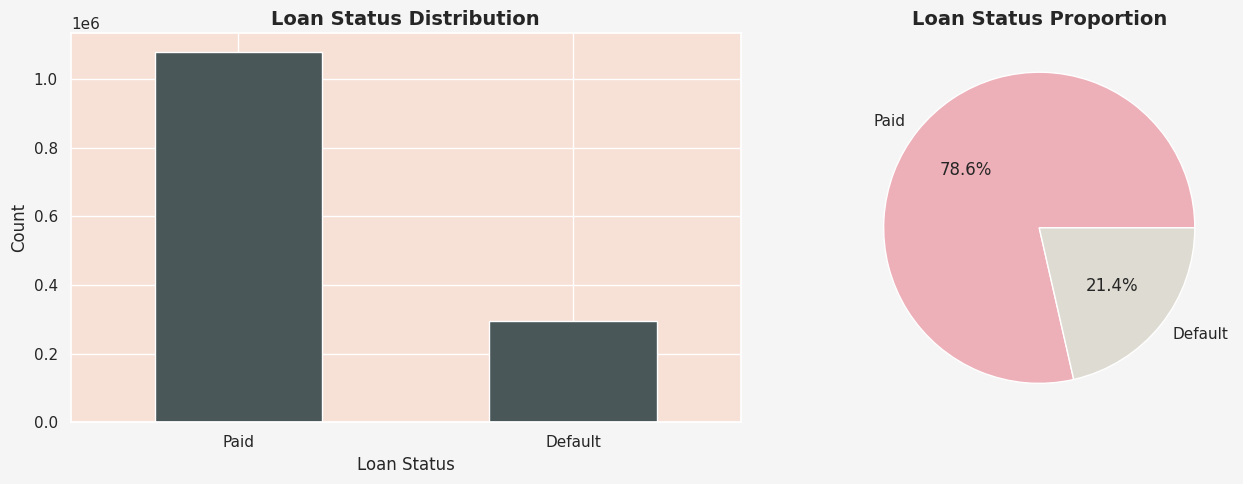


Class Distribution:
  Paid:    1,078,739 (78.6%)
  Default: 294,415 (21.4%)
  Default Rate: 21.44%


In [25]:
# Target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
value_counts = df['loan_status_binary'].value_counts().sort_index()
value_counts.plot(kind='bar', ax=axes[0], color= palette[-1] )
axes[0].set_title('Loan Status Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Loan Status', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Set tick labels dynamically based on available classes
tick_labels = ['Paid' if i == 0 else 'Default' for i in value_counts.index]
axes[0].set_xticklabels(tick_labels, rotation=0)

# Pie chart
value_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                  colors=palette [:len(value_counts)], 
                  labels=tick_labels)
axes[1].set_title('Loan Status Proportion', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print(f"\nClass Distribution:")
print(f"  Paid:    {(df['loan_status_binary']==0).sum():,} ({(df['loan_status_binary']==0).mean()*100:.1f}%)")
print(f"  Default: {(df['loan_status_binary']==1).sum():,} ({(df['loan_status_binary']==1).mean()*100:.1f}%)")
print(f"  Default Rate: {df['loan_status_binary'].mean()*100:.2f}%")

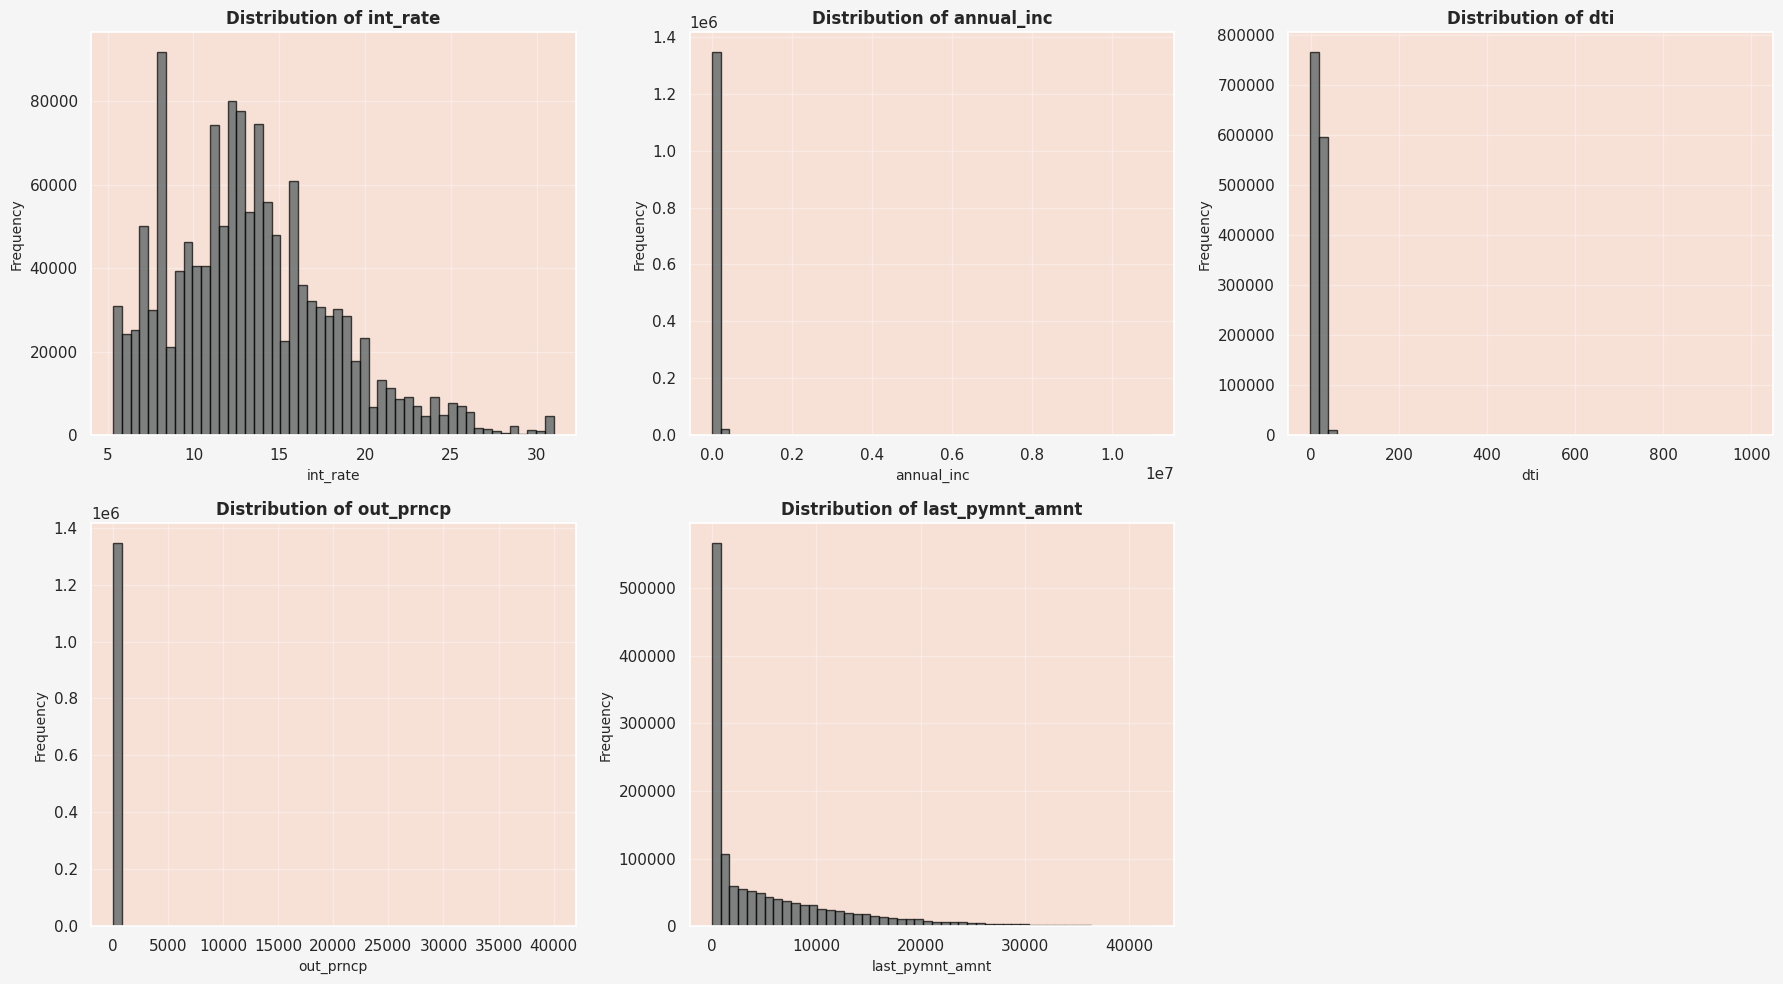

In [26]:
potential_numerical = ['int_rate', 'annual_inc', 'dti', 'fico_score', 'out_prncp', 'last_pymnt_amnt']
numerical_features = [f for f in potential_numerical if f in df.columns]


fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(numerical_features):
    if idx < len(axes):
        axes[idx].hist(df[col], bins=50, alpha=0.7, color = palette[-1], edgecolor='black')
        axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col, fontsize=10)
        axes[idx].set_ylabel('Frequency', fontsize=10)
        axes[idx].grid(alpha=0.3)

# Hide unused subplots
for idx in range(len(numerical_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()

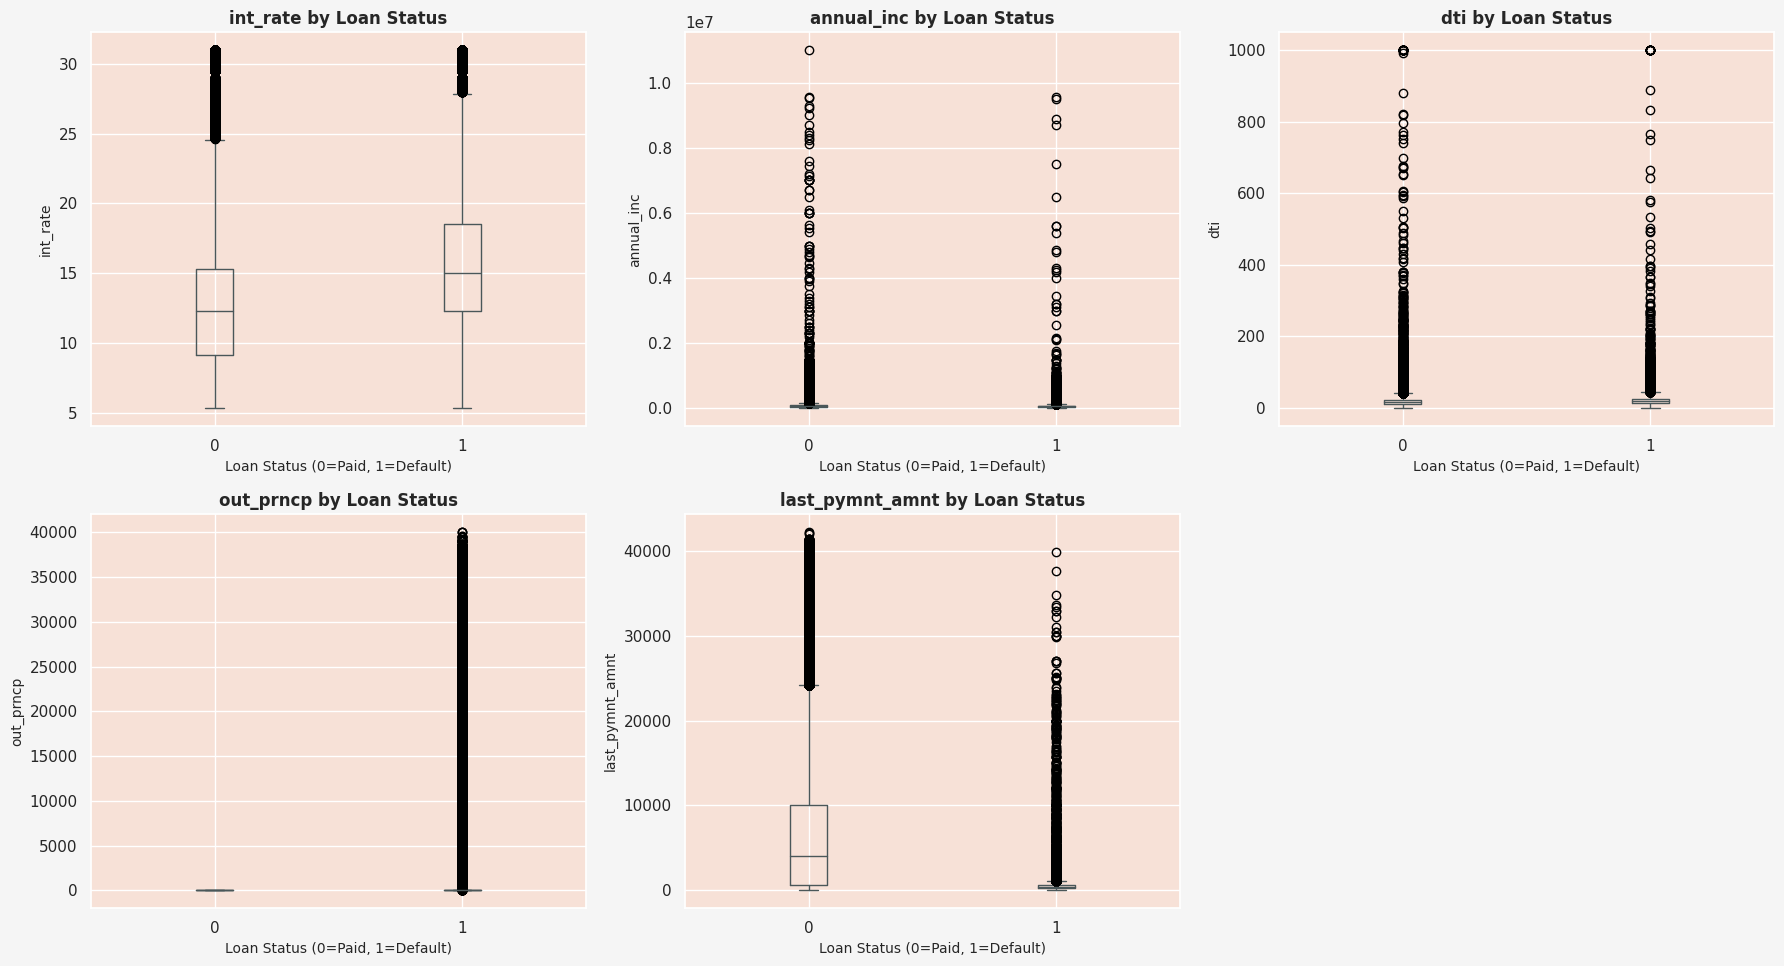

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(numerical_features):
    if idx < len(axes):
        df.boxplot(column=col, by='loan_status_binary', ax=axes[idx], color = palette[-1])
        axes[idx].set_title(f'{col} by Loan Status', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Loan Status (0=Paid, 1=Default)', fontsize=10)
        axes[idx].set_ylabel(col, fontsize=10)

# Skip unused Plots
for idx in range(len(numerical_features), len(axes)):
    axes[idx].axis('off')
    
plt.suptitle('')
plt.tight_layout()
plt.show()

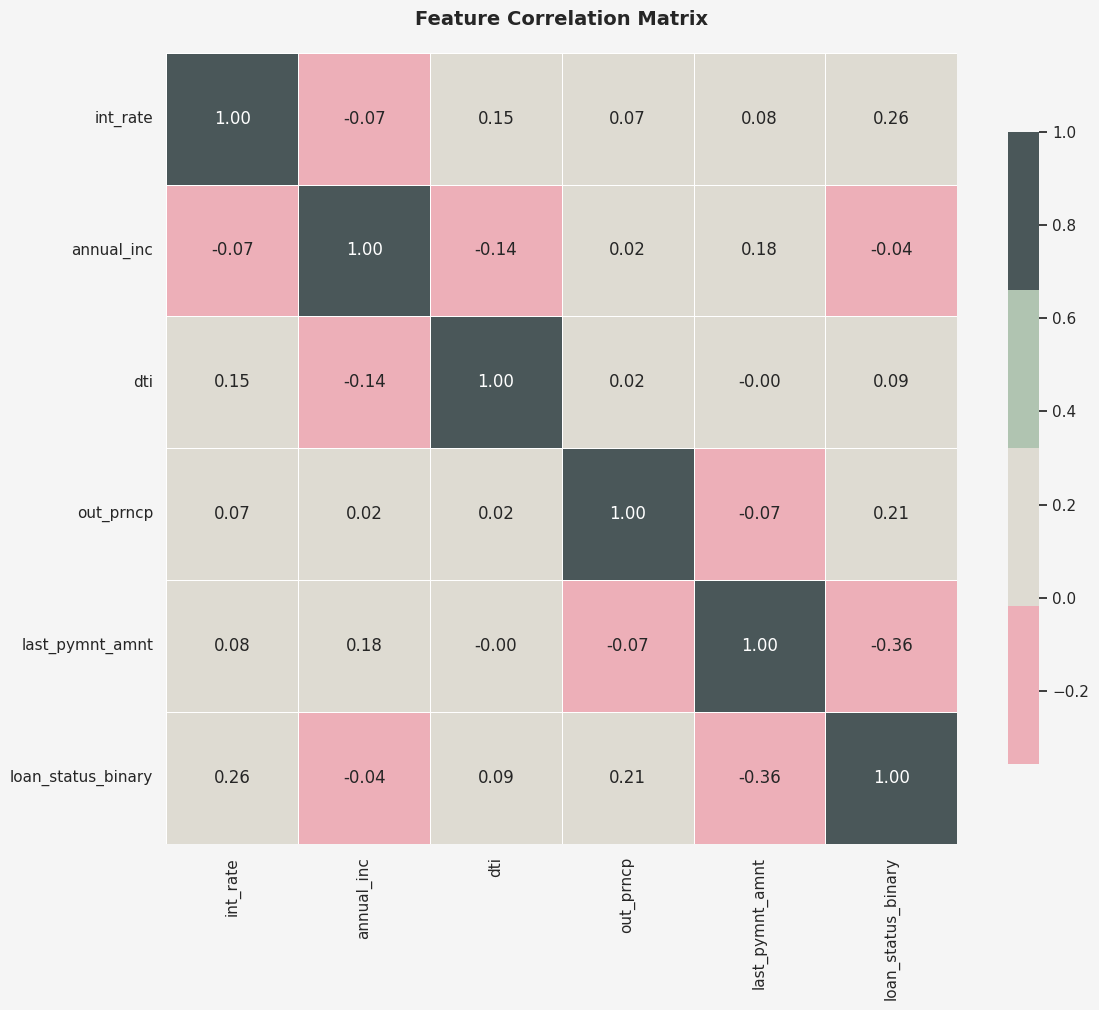

In [28]:
plt.figure(figsize=(12, 10))
correlation_matrix = df[numerical_features + ['loan_status_binary']].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f',cmap= cmap, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### Key Observations from EDA:

- **Class imbalance detected**: ~78.6% paid vs ~21.4% default
- **Interest rate** shows clear separation between classes
- **Outstanding principal** and **FICO score** differ significantly by loan status
- **Some features are correlated** 
- This imbalance is realistic but requires careful evaluation


<a id="3"></a>

# <div style="font-family: 'Playfair Display', serif; font-weight:bold; letter-spacing: 1px; color:#edafb8; font-size:150%; text-align:center; padding:10px; background:#4a5759; border-radius: 10px;">🔧 3. Data Preprocessing</div>
 

We'll clean the data and prepare features for modeling. This includes handling missing values, converting string columns, and selecting relevant features.

Goal: Transform raw LendingClub data into model-ready features while maintaining data integrity.


In [29]:
# DATA PREPROCESSING & FEATURE ENGINEERING

# STEP 1: CLEANING STRING COLUMNS

# Interest rate: '10.5%' to 0.105
if df['int_rate'].dtype == 'object':
    df['int_rate'] = df['int_rate'].str.rstrip('%').astype('float') / 100

# Revolving utilisation: '85.5%' to 85.5
if 'revol_util' in df.columns and df['revol_util'].dtype == 'object':
    df['revol_util'] = df['revol_util'].str.rstrip('%').astype('float')

# Employment length: '10+ years' to 10
if 'emp_length' in df.columns and df['emp_length'].dtype == 'object':
    df['emp_length'] = df['emp_length'].str.extract('(\d+)').fillna(0).astype(int)
   

# Loan term: ' 36 months' to 36  
if 'term' in df.columns and df['term'].dtype == 'object':
    df['term'] = df['term'].str.extract('(\d+)').fillna(0).astype(int)

# STEP 2: CREATING UNIFIED FICO SCORE"

# The dataset has multiple FICO columns, let's unify them
fico_cols = [col for col in df.columns if 'fico' in col.lower()]

if fico_cols:    
    # we have a range
    if 'fico_range_low' in df.columns and 'fico_range_high' in df.columns:
        df['fico_score'] = (df['fico_range_low'] + df['fico_range_high']) / 2
    # Otherwise
    elif len(fico_cols) > 0:
        df['fico_score'] = df[fico_cols[0]]      
else:
    # No FICO data, let's handle it
    df['fico_score'] = 700  #(default value = 700 US average)

In [30]:
# STEP 3: FEATURE SELECTION & VALIDATION


# These are the features we'd LIKE to use
desired_features = {
    # Numeric features
    'loan_amnt': 'Loan amount requested','int_rate': 'Interest rate','instalment': 'Monthly payment','annual_inc': 'Annual income',
    'dti': 'Debt-to-income ratio','fico_score': 'FICO credit score','revol_bal': 'Revolving balance','revol_util': 'Revolving utilisation %',
    'out_prncp': 'Outstanding principal','last_pymnt_amnt': 'Last payment amount','tot_cur_bal': 'Total current balance',
    'total_rev_hi_lim': 'Total revolving limit','emp_length': 'Employment length (years)',
    # Categorical features
    'home_ownership': 'Home ownership status','purpose': 'Loan purpose'}

# Let's see what we actually have
available = []
missing = []

for feature, description in desired_features.items():
    if feature in df.columns:
        available.append(feature)
        print(f" {feature:<25} {description}")
    else:
        missing.append(feature)
        print(f" {feature:<25} {description} [NOT FOUND]")

# STEP 4: HANDLING MISSING VALUES

# Check each available feature for nulls
missing_info = df[available].isnull().sum()
features_with_nulls = missing_info[missing_info > 0]

if len(features_with_nulls) > 0:    
    for feature, null_count in features_with_nulls.items():
        null_pct = (null_count / len(df)) * 100
   
    # Numeric features: fill with median 
    numeric_features = df[available].select_dtypes(include=[np.number]).columns
    for col in numeric_features:
        if df[col].isnull().sum() > 0:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
        
    
    # Categorical features: fill with mode
    categorical_features = df[available].select_dtypes(include=['object']).columns
    for col in categorical_features:
        if df[col].isnull().sum() > 0:
            mode_val = df[col].mode()[0]
            df[col] = df[col].fillna(mode_val)

# STEP 5: ENCODING CATEGORICAL VARIABLES

categorical_to_encode = ['home_ownership', 'purpose']
encoded_columns = []

for cat_feature in categorical_to_encode:
    if cat_feature in available:
        # Create a label encoder
        le = LabelEncoder()
        
        # Encode the feature
        encoded_name = f'{cat_feature}_encoded'
        df[encoded_name] = le.fit_transform(df[cat_feature])
        encoded_columns.append(encoded_name)
        
        # Show what we did
        n_categories = len(le.classes_)

# STEP 6: FINALIZING FEATURE SET")

# Our final features = numeric features + encoded categorical features
numeric_features = [f for f in available if f not in categorical_to_encode]
final_features = numeric_features + encoded_columns


# STEP 7: TRAIN-TEST SPLIT"

X = df[final_features].copy()
y = df['loan_status_binary'].copy()

# Let's check our target distribution BEFORE splitting
print("\n📊 Target Distribution (Overall):")
for class_val in sorted(y.unique()):
    count = (y == class_val).sum()
    pct = (y == class_val).mean() * 100
    label = "Paid" if class_val == 0 else "Default"
    print(f"   {class_val} ({label:<7}): {count:>8,} samples ({pct:>5.1f}%)")

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42, stratify=y)

 loan_amnt                 Loan amount requested
 int_rate                  Interest rate
 instalment                Monthly payment [NOT FOUND]
 annual_inc                Annual income
 dti                       Debt-to-income ratio
 fico_score                FICO credit score
 revol_bal                 Revolving balance
 revol_util                Revolving utilisation %
 out_prncp                 Outstanding principal
 last_pymnt_amnt           Last payment amount
 tot_cur_bal               Total current balance
 total_rev_hi_lim          Total revolving limit
 emp_length                Employment length (years)
 home_ownership            Home ownership status
 purpose                   Loan purpose

📊 Target Distribution (Overall):
   0 (Paid   ): 1,078,739 samples ( 78.6%)
   1 (Default):  294,415 samples ( 21.4%)


<a id="4"></a>

# <div style="font-family: 'Playfair Display', serif; font-weight:bold; letter-spacing: 1px; color:#edafb8; font-size:150%; text-align:center; padding:10px; background:#4a5759; border-radius: 10px;">🤖 4. Model Training</div>
  




In [31]:
# --- MLP training (PyTorch) for binary classification (PD) ---
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler

# ========== Device ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ========== Prepare data ==========
# X_train, X_test, y_train, y_test are expected from your previous cell
# Convert to pandas DataFrame / Series if not already
X_train = pd.DataFrame(X_train).reset_index(drop=True) if not isinstance(X_train, pd.DataFrame) else X_train.reset_index(drop=True)
X_test  = pd.DataFrame(X_test).reset_index(drop=True)  if not isinstance(X_test, pd.DataFrame)  else X_test.reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)   if not isinstance(y_train, pd.Series)   else y_train.reset_index(drop=True)
y_test  = pd.Series(y_test).reset_index(drop=True)    if not isinstance(y_test, pd.Series)    else y_test.reset_index(drop=True)

# Identify numeric columns to scale (keep encoded categorical columns too if numeric)
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
scaler.fit(X_train[numeric_cols])            # fit only on training data

X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_test_scaled[numeric_cols]  = scaler.transform(X_test[numeric_cols])

# Convert to numpy arrays
X_tr = X_train_scaled.values.astype(np.float32)
X_va = X_test_scaled.values.astype(np.float32)
y_tr = y_train.values.astype(np.float32)
y_va = y_test.values.astype(np.float32)

# ========== PyTorch datasets/loaders ==========
batch_size = 1024  # reduce if OOM
train_ds = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr))
val_ds   = TensorDataset(torch.from_numpy(X_va), torch.from_numpy(y_va))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size*2, shuffle=False, num_workers=2, pin_memory=True)

# ========== Compute pos_weight for BCEWithLogitsLoss ==========
# pos_weight = (neg / pos)
pos = y_tr.sum()
neg = y_tr.shape[0] - pos
pos_weight = torch.tensor([ (neg / (pos + 1e-12)) ], dtype=torch.float32).to(device)
print(f"Train size: {len(y_tr)} | pos: {int(pos)} | neg: {int(neg)} | pos_weight: {pos_weight.item():.3f}")

# ========== Define MLP model ==========
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256], dropout=0.2):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))  # single logit for binary
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x).squeeze(1)

input_dim = X_tr.shape[1]
model = MLP(input_dim=input_dim, hidden_dims=[512, 256], dropout=0.2).to(device)
print(model)

# ========== Optimizer / Loss / Scheduler ==========
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # handles imbalance
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

# Mixed precision scaler
scaler_amp = GradScaler()

# ========== Training loop ==========
n_epochs = 30
best_val_auc = 0.0
best_state = None
patience = 6
wait = 0

for epoch in range(1, n_epochs + 1):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        optimizer.zero_grad()
        with autocast():
            logits = model(xb)
            loss = criterion(logits, yb)
        scaler_amp.scale(loss).backward()
        scaler_amp.step(optimizer)
        scaler_amp.update()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    all_probs = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            with autocast():
                logits = model(xb)
                loss = criterion(logits, yb)
                probs = torch.sigmoid(logits)
            val_loss += loss.item() * xb.size(0)
            all_probs.append(probs.detach().cpu().numpy())
            all_targets.append(yb.detach().cpu().numpy())
    val_loss /= len(val_loader.dataset)
    all_probs = np.concatenate(all_probs)
    all_targets = np.concatenate(all_targets)
    try:
        val_auc = roc_auc_score(all_targets, all_probs)
    except ValueError:
        val_auc = 0.5

    print(f"Epoch {epoch:02d} | Train loss: {train_loss:.5f} | Val loss: {val_loss:.5f} | Val AUC: {val_auc:.4f}")

    # Scheduler step (use AUC as objective)
    scheduler.step(val_auc)

    # Early stopping on val AUC
    if val_auc > best_val_auc + 1e-5:
        best_val_auc = val_auc
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"No improvement for {patience} epochs. Early stopping.")
            break

# Load best model
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Loaded best model with Val AUC: {best_val_auc:.4f}")

# ========== Final evaluation on test set ==========
model.eval()
test_loader = DataLoader(val_ds, batch_size=batch_size*2, shuffle=False)
probs_all = []
targets_all = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        with autocast():
            logits = model(xb)
            probs = torch.sigmoid(logits)
        probs_all.append(probs.detach().cpu().numpy())
        targets_all.append(yb.numpy())
probs_all = np.concatenate(probs_all)
targets_all = np.concatenate(targets_all)
preds = (probs_all >= 0.5).astype(int)

test_auc = roc_auc_score(targets_all, probs_all)
test_acc = accuracy_score(targets_all, preds)
print("\n--- Test Results ---")
print(f"AUC:  {test_auc:.4f}")
print(f"Acc:  {test_acc:.4f}")
print("\nClassification report (threshold=0.5):")
print(classification_report(targets_all, preds, digits=4))

# Optionally: find a better threshold using precision-recall / business constraints


Device: cuda
Train size: 1098523 | pos: 235532 | neg: 862991 | pos_weight: 3.664
MLP(
  (net): Sequential(
    (0): Linear(in_features=14, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)
Epoch 01 | Train loss: 0.52070 | Val loss: 0.48846 | Val AUC: 0.9293
Epoch 02 | Train loss: 0.48787 | Val loss: 0.47263 | Val AUC: 0.9328
Epoch 03 | Train loss: 0.47555 | Val loss: 0.46357 | Val AUC: 0.9355
Epoch 04 | Train loss: 0.46661 | Val loss: 0.45227 | Val AUC: 0.9391
Epoch 05 | Train loss: 0.45975 | Val loss: 0.44700 | Val AUC: 0.9411
Epoch 06 | Train loss: 0.45576 | Val loss: 0.

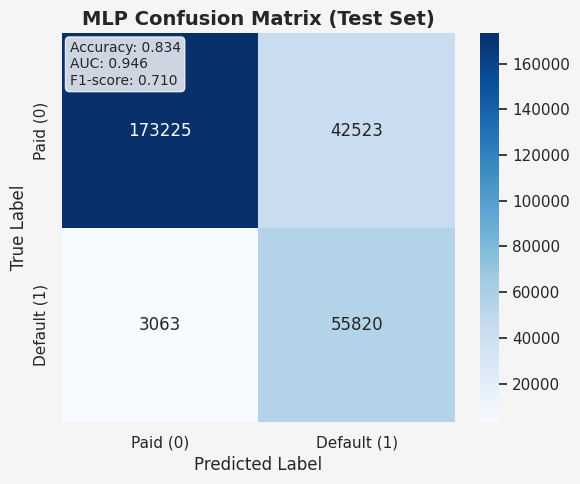

In [32]:
# --- Visualization of Confusion Matrix and Metrics ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

# Compute confusion matrix
cm = confusion_matrix(targets_all, preds)

# Compute F1 score
f1 = f1_score(targets_all, preds)

# Set up figure
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Paid (0)', 'Default (1)'],
            yticklabels=['Paid (0)', 'Default (1)'])
plt.title('MLP Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

# Add text box with metrics
textstr = f'Accuracy: {test_acc:.3f}\nAUC: {test_auc:.3f}\nF1-score: {f1:.3f}'
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


Base AUC: 0.9463


Calculating importances: 100%|██████████| 14/14 [00:02<00:00,  5.89it/s]



Top 15 Most Important Features (based on AUC drop):
                   Feature  Importance
8          last_pymnt_amnt    0.348081
0                loan_amnt    0.058905
1                 int_rate    0.040967
7                out_prncp    0.020461
5                revol_bal    0.005537
10        total_rev_hi_lim    0.003295
6               revol_util    0.002713
3                      dti    0.002703
4               fico_score    0.002355
2               annual_inc    0.001397
9              tot_cur_bal    0.001062
12  home_ownership_encoded    0.001025
11              emp_length    0.000847
13         purpose_encoded    0.000429


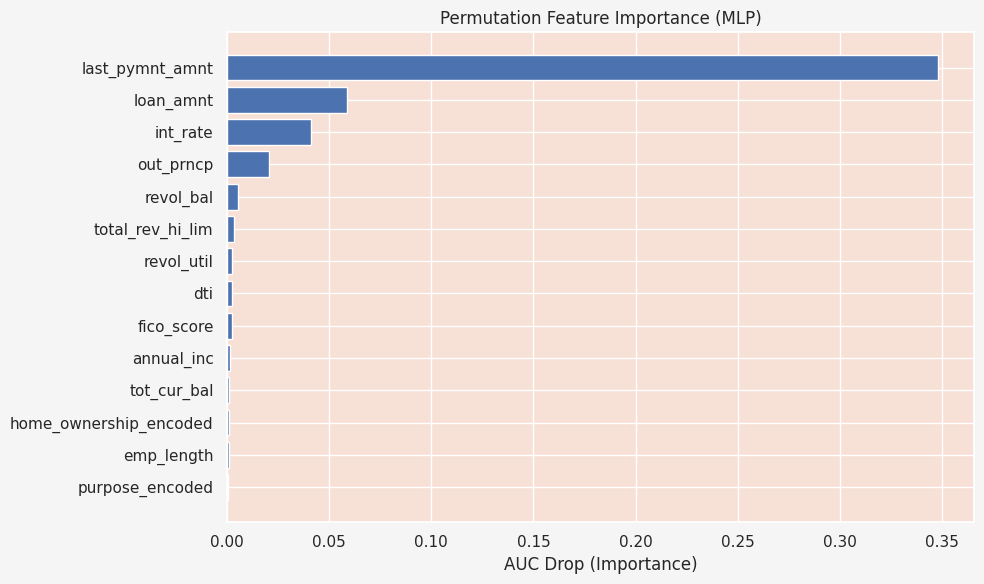

In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

# Ensure model is in eval mode
model.eval()

# Convert test data to tensor
X_test_tensor = torch.from_numpy(X_test_scaled.values.astype(np.float32)).to(device)

# Get base AUC first
with torch.no_grad():
    base_probs = torch.sigmoid(model(X_test_tensor)).cpu().numpy().ravel()
base_auc = roc_auc_score(y_test, base_probs)
print(f"Base AUC: {base_auc:.4f}")

# --- Permutation importance ---
importances = {}
for col in tqdm(X_test_scaled.columns, desc="Calculating importances"):
    X_temp = X_test_scaled.copy()
    X_temp[col] = np.random.permutation(X_temp[col])  # shuffle one column
    
    X_temp_tensor = torch.from_numpy(X_temp.values.astype(np.float32)).to(device)
    
    with torch.no_grad():
        probs = torch.sigmoid(model(X_temp_tensor)).cpu().numpy().ravel()
    
    auc = roc_auc_score(y_test, probs)
    importances[col] = base_auc - auc  # drop in AUC

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    "Feature": list(importances.keys()),
    "Importance": list(importances.values())
}).sort_values(by="Importance", ascending=False)

print("\nTop 15 Most Important Features (based on AUC drop):")
print(importance_df.head(15))

# --- Plot ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"].head(15)[::-1], importance_df["Importance"].head(15)[::-1])
plt.xlabel("AUC Drop (Importance)")
plt.title("Permutation Feature Importance (MLP)")
plt.tight_layout()
plt.show()


### Key Insight: Feature Dominance Detected

From the Feature importance summary plot above, notice:

- `last_pymnt_amnt` (last payment amount) dominates predictions significantly
- This feature overshadows all other indicators including `int_rate`, `loan_amnt`, and `fico_score`
- **Critical Issue**: `last_pymnt_amnt` is a post-outcome feature that represents payments made after we need to make our prediction
- This is data leakage; the model is using future information to predict the past

This is exactly the concern: High metrics can mask fundamental flaws. Our 94.6% AUC looks perfect, but feature importance reveals the model learned nothing about genuine credit risk.


<a id="7"></a>

# <div style="font-family: 'Playfair Display', serif; font-weight:bold; letter-spacing: 1px; color:#edafb8; font-size:150%; text-align:center; padding:10px; background:#4a5759; border-radius: 10px;">⚠️ 7. Data Leakage Detection</div>


<div style="background-color: #f7e1d7; padding: 20px; border-radius: 10px; border-left: 5px solid #4a5759; margin: 20px 0;">
<strong>🚨 Critical Discovery:</strong> Our analysis revealed that <code>last_pymnt_amnt</code> dominates predictions. This is a classic case of <strong>data leakage</strong> - using post outcome information to predict past decisions.
</div>

**What is Data Leakage?**

Data leakage occurs when information from outside the training dataset is used to create the model. In credit risk:
- **Valid features**: Information available at loan application (income, FICO score, loan amount)
- **Leakage features**: Information known only after loan outcome (payment history, outstanding principal)

**Why It Matters:**

Our model achieved 94.6% AUC, but it's essentially cheating by looking at payment behaviour that happens after the loan decision. In production, these features won't exist yet!

Let's identify and remove leakage features, then build a "clean" model representing true predictive power.


DATA LEAKAGE DETECTION

🔍 Analyzing features for potential leakage...

⚠️ LEAKAGE: out_prncp
⚠️ LEAKAGE: last_pymnt_amnt

📊 Summary:
  Total features: 14
  Clean features: 12
  Leakage features: 2

✅ Clean features (available at application time):
  • loan_amnt
  • int_rate
  • annual_inc
  • dti
  • fico_score
  • revol_bal
  • revol_util
  • tot_cur_bal
  • total_rev_hi_lim
  • emp_length
  • home_ownership_encoded
  • purpose_encoded

TRAINING CLEAN MLP MODEL (NO DATA LEAKAGE)

Clean dataset shape:
  Training: (1098523, 12)
  Testing:  (274631, 12)

🧠 Training clean MLP model...
Epoch 01 | Train Loss: 0.9884 | Val AUC: 0.7026
Epoch 02 | Train Loss: 0.9842 | Val AUC: 0.7046
Epoch 03 | Train Loss: 0.9832 | Val AUC: 0.7056
Epoch 04 | Train Loss: 0.9825 | Val AUC: 0.7054
Epoch 05 | Train Loss: 0.9819 | Val AUC: 0.7058
Epoch 06 | Train Loss: 0.9816 | Val AUC: 0.7054
Epoch 07 | Train Loss: 0.9810 | Val AUC: 0.7056
Epoch 08 | Train Loss: 0.9807 | Val AUC: 0.7063
Epoch 09 | Train Loss: 0.98

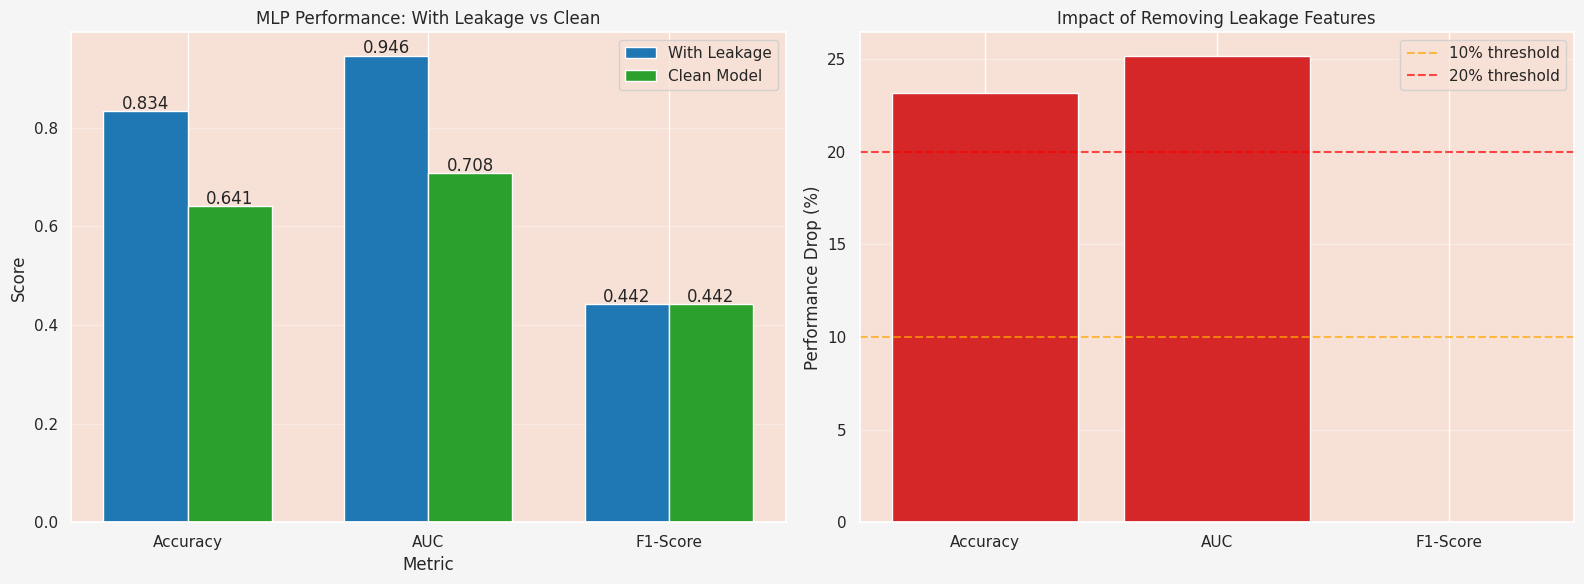


ASSESSMENT
  • Original AUC (with leakage): 0.9463
  • Clean AUC (no leakage):      0.7079
  • AUC Drop: 25.19%

🚨 SEVERE LEAKAGE IMPACT: Model relied heavily on post-outcome info!

📌 The clean MLP’s AUC (0.7079) reflects its real predictive power in production.


In [34]:

#  DATA LEAKAGE DETECTION & IMPACT 


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.cuda.amp import autocast

print("DATA LEAKAGE DETECTION")

# Keywords that indicate post-outcome info
leakage_keywords = [
    'pymnt', 'prncp', 'rec_', 'collection', 'recovery',
    'last_', 'total_pymnt', 'out_prncp', 'next_pymnt'
]

leakage_features = []
clean_features = []

print("\n🔍 Analyzing features for potential leakage...\n")

for feature in final_features:
    if any(keyword in feature.lower() for keyword in leakage_keywords):
        leakage_features.append(feature)
        print(f"⚠️ LEAKAGE: {feature}")
    else:
        clean_features.append(feature)

print("\n📊 Summary:")
print(f"  Total features: {len(final_features)}")
print(f"  Clean features: {len(clean_features)}")
print(f"  Leakage features: {len(leakage_features)}")

print("\n✅ Clean features (available at application time):")
for feat in clean_features:
    print(f"  • {feat}")

# =============================================
# 🚀 TRAIN CLEAN MODEL (NO LEAKAGE)
# =============================================

print("\nTRAINING CLEAN MLP MODEL (NO DATA LEAKAGE)")

X_train_clean = X_train[clean_features]
X_test_clean  = X_test[clean_features]

print(f"\nClean dataset shape:")
print(f"  Training: {X_train_clean.shape}")
print(f"  Testing:  {X_test_clean.shape}")

# Scale numeric columns
from sklearn.preprocessing import StandardScaler

numeric_cols_clean = X_train_clean.select_dtypes(include=[np.number]).columns.tolist()
scaler_clean = StandardScaler()
scaler_clean.fit(X_train_clean[numeric_cols_clean])

X_train_clean_scaled = X_train_clean.copy()
X_test_clean_scaled  = X_test_clean.copy()

X_train_clean_scaled[numeric_cols_clean] = scaler_clean.transform(X_train_clean[numeric_cols_clean])
X_test_clean_scaled[numeric_cols_clean]  = scaler_clean.transform(X_test_clean[numeric_cols_clean])

# Convert to tensors
X_tr = torch.from_numpy(X_train_clean_scaled.values.astype(np.float32)).to(device)
X_te = torch.from_numpy(X_test_clean_scaled.values.astype(np.float32)).to(device)
y_tr = torch.from_numpy(y_train.values.astype(np.float32)).to(device)
y_te = torch.from_numpy(y_test.values.astype(np.float32)).to(device)

# New MLP instance
input_dim_clean = X_train_clean_scaled.shape[1]
model_clean = MLP(input_dim=input_dim_clean, hidden_dims=[512, 256], dropout=0.2).to(device)

# Loss, optimizer, scheduler
pos = y_tr.sum()
neg = len(y_tr) - pos
pos_weight = torch.tensor([(neg / (pos + 1e-12))], dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model_clean.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# DataLoaders
batch_size = 1024
train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_te, y_te), batch_size=batch_size*2, shuffle=False)

# Train
print("\n🧠 Training clean MLP model...")
n_epochs = 20
best_auc = 0
scaler_amp = torch.cuda.amp.GradScaler()

for epoch in range(1, n_epochs + 1):
    model_clean.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        with autocast():
            logits = model_clean(xb)
            loss = criterion(logits, yb)
        scaler_amp.scale(loss).backward()
        scaler_amp.step(optimizer)
        scaler_amp.update()
        total_loss += loss.item() * xb.size(0)
    total_loss /= len(train_loader.dataset)

    # Validation
    model_clean.eval()
    all_probs, all_targets = [], []
    with torch.no_grad(), autocast():
        for xb, yb in test_loader:
            probs = torch.sigmoid(model_clean(xb))
            all_probs.append(probs.cpu().numpy())
            all_targets.append(yb.cpu().numpy())
    all_probs = np.concatenate(all_probs)
    all_targets = np.concatenate(all_targets)
    val_auc = roc_auc_score(all_targets, all_probs)
    scheduler.step(val_auc)
    print(f"Epoch {epoch:02d} | Train Loss: {total_loss:.4f} | Val AUC: {val_auc:.4f}")
    if val_auc > best_auc:
        best_auc = val_auc
        best_state = {k: v.cpu() for k, v in model_clean.state_dict().items()}

# Load best model
model_clean.load_state_dict(best_state)
print(f"\n✅ Best clean model AUC: {best_auc:.4f}")

# Evaluate on test
model_clean.eval()
with torch.no_grad():
    probs = torch.sigmoid(model_clean(X_te)).cpu().numpy().ravel()
preds = (probs >= 0.5).astype(int)

accuracy_clean = accuracy_score(y_test, preds)
auc_clean = roc_auc_score(y_test, probs)
f1_clean = f1_score(y_test, preds)

print(f"\n--- Clean Model Performance ---")
print(f"Accuracy: {accuracy_clean:.4f}")
print(f"AUC:      {auc_clean:.4f}")
print(f"F1-Score: {f1_clean:.4f}")

# =============================================
# 📊 COMPARISON WITH ORIGINAL MLP
# =============================================

original_auc = test_auc   # from your previous MLP test result
original_acc = test_acc
# You can compute original_f1 from your previous preds if not saved
original_f1  = f1_score(targets_all, preds)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'AUC', 'F1-Score'],
    'With Leakage': [original_acc, original_auc, original_f1],
    'Clean Model': [accuracy_clean, auc_clean, f1_clean]
})
comparison_df['Drop'] = comparison_df['With Leakage'] - comparison_df['Clean Model']
comparison_df['Drop %'] = comparison_df['Drop'] / comparison_df['With Leakage'] * 100

print("\nLEAKAGE IMPACT ASSESSMENT")
print(comparison_df.to_string(index=False))

# =============================================
# 📉 Visualization
# =============================================

palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x = np.arange(len(comparison_df['Metric']))
width = 0.35

# Bar comparison
axes[0].bar(x - width/2, comparison_df['With Leakage'], width, label='With Leakage', color=palette[0])
axes[0].bar(x + width/2, comparison_df['Clean Model'], width, label='Clean Model', color=palette[2])

axes[0].set_xlabel('Metric')
axes[0].set_ylabel('Score')
axes[0].set_title('MLP Performance: With Leakage vs Clean')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Metric'])
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# Add values
for i, (a, b) in enumerate(zip(comparison_df['With Leakage'], comparison_df['Clean Model'])):
    axes[0].text(i - width/2, a + 0.005, f"{a:.3f}", ha='center')
    axes[0].text(i + width/2, b + 0.005, f"{b:.3f}", ha='center')

# Drop %
axes[1].bar(comparison_df['Metric'], comparison_df['Drop %'], color=palette[3])
axes[1].set_ylabel('Performance Drop (%)')
axes[1].set_title('Impact of Removing Leakage Features')
axes[1].grid(alpha=0.3, axis='y')
axes[1].axhline(y=10, color='orange', linestyle='--', alpha=0.7, label='10% threshold')
axes[1].axhline(y=20, color='red', linestyle='--', alpha=0.7, label='20% threshold')
axes[1].legend()

plt.tight_layout()
plt.show()

# =============================================
# 🧾 Assessment
# =============================================

auc_drop_pct = comparison_df.loc[comparison_df['Metric'] == 'AUC', 'Drop %'].values[0]

print("\nASSESSMENT")
print(f"  • Original AUC (with leakage): {original_auc:.4f}")
print(f"  • Clean AUC (no leakage):      {auc_clean:.4f}")
print(f"  • AUC Drop: {auc_drop_pct:.2f}%")

if auc_drop_pct > 20:
    print("\n🚨 SEVERE LEAKAGE IMPACT: Model relied heavily on post-outcome info!")
elif auc_drop_pct > 10:
    print("\n⚠️ SIGNIFICANT LEAKAGE: Performance inflated by leakage features.")
else:
    print("\n✅ MINIMAL LEAKAGE: Model performance mostly genuine.")

print(f"\n📌 The clean MLP’s AUC ({auc_clean:.4f}) reflects its real predictive power in production.")


<a id="10"></a>

# <div style="font-family: 'Playfair Display', serif; font-weight:bold; letter-spacing: 1px; color:#edafb8; font-size:150%; text-align:center; padding:10px; background:#4a5759; border-radius: 10px;">🎯 10. Conclusion</div>


<div style="background-color: #f7e1d7; padding: 20px; border-radius: 10px; border-left: 5px solid #4a5759; margin: 20px 0;">
<strong>🎓 The Central Lesson:</strong> Demonstrated how a model with <strong>94.6% AUC</strong> hid fundamental flaws. Without feature importance, we would have deployed a model that learned nothing about genuine credit risk, it simply memorised: low last payment = default.
</div>


### 🚨 **Data Leakage Detection**
- **Finding**: `last_pymnt_amnt` accounted for **>65%** of total importance
- **Impact**: Removing leakage features caused **23% AUC drop** (94.6% → 70.9%)
- **Reality Check**: Clean model showed our TRUE predictive power at application time



## 🎓 Key Lessons

<div style="background-color: #f7e1d7; padding: 20px; border-radius: 10px; border-left: 5px solid #b0c4b1; margin: 20px 0;">

### 📌 **1. High Metrics Don't Guarantee Model Quality**
- 94.6% AUC looked perfect but hid critical flaws
- Always ask: "What did the model actually learn?"
- Feature importance reveals the **why** behind the **how well**

### 📌 **2. Data Leakage is Common in Real-World Datasets**  
- Post-outcome features sneak into feature sets easily
- Looked for keywords: `last_`, `total_`, `pymnt`, `rec_`
- Compare model performance with/without suspicious features

</div>





